<a href="https://colab.research.google.com/github/Lucile-S/ART_project/blob/main/DCGAN_artist_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f
https://github.com/alex-lechner/PyTorch-GAN
https://towardsdatascience.com/gangogh-creating-art-with-gans-8d087d8f74a1
https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
https://www.linkedin.com/pulse/conditional-generative-adversarial-network-cgan-chinese-wang/

https://github.com/rkjones4/GANGogh

https://github.com/Adi-iitd/AI-Art
https://github.com/robbiebarrat/art-DCGAN

https://levelup.gitconnected.com/painting-portraits-using-gans-with-pytorch-afeb69b1c5a1

http://cs231n.stanford.edu/reports/2017/pdfs/311.pdf


https://github.com/znxlwm/pytorch-Conditional-image-to-image-translation/blob/master/train.py

https://github.com/ibrahimjelliti/Deeplearning.ai-GAN-Specialization-Generative-Adversarial-Networks/blob/master/1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%204/C1W4A_Build_a_Conditional_GAN.ipynb


https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f

# Packages 

In [1]:
! pip install --upgrade --quiet neptune-client==0.9.5
! pip install torchsummary

     |████████████████████████████████| 211 kB 16.4 MB/s 
     |████████████████████████████████| 829 kB 61.8 MB/s 
     |████████████████████████████████| 52 kB 2.1 MB/s 
     |████████████████████████████████| 180 kB 70.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 129 kB 74.1 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 


In [2]:
import os
from glob import iglob 
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import copy
import urllib
import time
from datetime import datetime
import collections 
from tqdm import tqdm
import torch
import json
import torchvision
import random
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import neptune.new as neptune
%matplotlib inline

pd.set_option('max_colwidth', None)
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def check_for_CUDA():
	"""Check whether CUDA is available
	Parameters
	----------
	target : object
		An object which contains attribute `config`
	"""

	if torch.cuda.is_available():
		print("CUDA is available!")
		print("Using {}".format(torch.device("cuda:0")))
	else:
		print("Cuda is NOT available, running on CPU.")
		print(torch.device("cpu"))

	
# check pytorch version and GPU
print(torch.__version__)
check_for_CUDA()

1.9.0+cu111
CUDA is available!
Using cuda:0


In [4]:
# -- To ensure reproductibility 
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#Intialise a random number generator
rng = np.random.default_rng(seed)

def _init_fn(worker_id):
  np.random.seed(int(seed))

# Mount DRIVE 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/MyDrive/ /mydrive

In [7]:
%cd mydrive

[Errno 2] No such file or directory: 'mydrive'
/content


In [8]:
!ls /mydrive/GAN

Data  generated  logs  Models


# Neptune AI connexion

In [9]:
# tags = ['pytorch', 'GAN']
# run_neptune = neptune.init(project='lucile.s/',
#                    api_token='',
#                    tags = tags) 

# Usefull Functions

In [10]:
def open_json_file(json_path):
    # Opening JSON file
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data 


def MakeDir(DIR:str) -> None:
    try:
        if not os.path.exists(DIR):
            os.makedirs(DIR)
    except OSError as err:
        print(err)
        pass

def dict_to_json(dictionary:dict, json_path:str) -> None:
    with open(json_path, "w", encoding='utf-8') as outfile: 
        json.dump(dictionary, outfile, indent=4)
        #print(f'json file saved in {json_path}')


def show_batch(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    try: 
      image_unflat = image_tensor.detach().cpu()
    except: 
      image_unflat = image_tensor
      
    plt.figure(figsize = (12,12))
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


def ImgChannelNb(image_path:str, show=False):
    # -- with cv2
    # print(cv2.imread(image_test, cv2.IMREAD_UNCHANGED).shape)
    # -- with Image (PIL)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if image.ndim ==2:
        channels =1
    else:
        channels = image.shape[-1]
    if show:
      print(f'Image has: {channels} channel(s)')
      print(f'Image size is : {image.shape}')
    return channels, image.shape


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

# Usefull Class

In [11]:
class Artist(object):
    """
    Artist Object
    """
    def __init__(self, folder_path:str, label_id=None ):
        self._path = folder_path.replace('\\',r'/')
        self._label_id = label_id

    @property
    def folder_name(self):
        return os.path.basename(self._path)

    @property
    def name(self):
      return os.path.basename(self._path).replace('-',' ').title()

    @property
    def path(self):
        return self._path
    
    @property
    def painting_paths(self):
        return list(iglob(self._path + '/*.jpg'))

    @property
    def painting_titles(self):
        return [ os.path.basename(painting_path).replace('.jpg','').replace('-',' ').capitalize() for painting_path in iglob(self._path + '/*.jpg') ]

    @property
    def painting_nb(self):
      return len(list(iglob(self._path + '/*.jpg')))

    @property
    def label(self):
        # just one label_id
        if isinstance(self._label_id, int):
            return self._label_id
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._label_id]
  

class Painting(object):
    """
    Painting Object
    """
    def __init__(self, painting_path:str):
        self._path = painting_path.replace('\\',r'/')
        self._json = self._path.replace('.jpg','.json')
        self._data = open_json_file(self._json)
        self._filename = os.path.basename(self._json).replace('.json','')
        self._key = list(self._data.keys())[0]

    @property
    def data(self):
      return  self._data


    @property
    def filename(self):
      return  self._filename


    @property
    def name(self):
      return  self._data[self._key]['Name']

    @property
    def artist(self):
      return  self._data[self._key]['Artist']



    @property
    def date(self):
      return self._data[self._key]['Date']
  
  
    @property
    def style(self):
      return self._data[self._key]['Style']
    
    @property
    def genre(self):
      return self._data[self._key]['Genre']

        
    @property
    def tags(self):
      return self._data[self._key]['Tags']


# DATA
postgre : https://docs.postgresql.fr/12/tutorial-createdb.html


In [12]:
artist_dict = {
  "Vincent Van Gogh": ["Naturalisme","Impressionnisme","Expressionisme"],
  "Joseph Mallord William Turner": ["Romantisme"],
  "Katsushika Hokusai":['Ukiyo-e'],
  "Zdzislaw Beksinski":["Surréalisme", "Réalisme magique","Avant-garde"],
  "Claude Monet": ["Impressionisme"],
  "Arnold Bocklin": ["Symbolisme"],
  "Piet Mondrian":["Néo-impressionnisme","De Stijl"],
  "Edward Hopper": ["Nouveau réalisme"],
  "Henri Rousseau": ['Primitivisme'],
  "Vassily Kandinsky": ["Abstrait"],
  "Gustav Klimt": ["Symbolisme", "Art nouveau"],
  "Sandro Botticelli" :["Renaissance"],
  "Artemisia Gentileschi":["Baroque"],
  "Pablo Picasso":["Cubisme"],
  "Henri Matisse": ["Impressionnisme"],
  "Pierre Auguste Renoir":["Impressionisme"],
  "Theophile Steinlen" : ["Art nouveau"],
  "David Burliuk" : ["Futurisme"],
  "Salvador Dali": ["Surréalisme"],
  "John James Audubon" :["Naturalisme"],
  "Ernst Ludwig Kirchner" :['Expressionisme'],
  "Rembrandt" : ['Baroque'],
  "Amedeo Modigliani" :['Expressionisme'],
    }


## load data

In [13]:
# -----------#
#    DATA    #
# -----------#

# -- image Directory 
DIR = '/mydrive/GAN' 
img_DIR = os.path.join(DIR,'Data')
artist_paths =  [ artist_path for artist_path  in iglob(img_DIR +'/*') if os.path.isdir(artist_path)]
# -- list of Artist instance
ARTISTS  = [Artist(artist_path) for artist_path in artist_paths]
print(f'There are {len(artist_paths)} artists')
print(artist_paths)

artist_csv_path = os.path.join(img_DIR, 'Artists.csv')
df_artist = pd.read_csv(artist_csv_path, sep=";")
painting_csv_path = os.path.join(img_DIR, 'Paintings.csv')

There are 22 artists
['/mydrive/GAN/Data/zdzislaw-beksinski', '/mydrive/GAN/Data/rembrandt', '/mydrive/GAN/Data/arnold-bocklin', '/mydrive/GAN/Data/gustav-klimt', '/mydrive/GAN/Data/katsushika-hokusai', '/mydrive/GAN/Data/pablo-picasso', '/mydrive/GAN/Data/vincent-van-gogh', '/mydrive/GAN/Data/ernst-ludwig-kirchner', '/mydrive/GAN/Data/theophile-steinlen', '/mydrive/GAN/Data/joseph-mallord-william-turner', '/mydrive/GAN/Data/sandro-botticelli', '/mydrive/GAN/Data/amedeo-modigliani', '/mydrive/GAN/Data/artemisia-gentileschi', '/mydrive/GAN/Data/piet-mondrian', '/mydrive/GAN/Data/edward-hopper', '/mydrive/GAN/Data/pierre-auguste-renoir', '/mydrive/GAN/Data/claude-monet', '/mydrive/GAN/Data/henri-rousseau', '/mydrive/GAN/Data/henri-matisse', '/mydrive/GAN/Data/david-burliuk', '/mydrive/GAN/Data/john-james-audubon', '/mydrive/GAN/Data/vassily-kandinsky']


## Artist label Mapping dictionnary

In [14]:
# -- create mapping dictionnary for Artist (in alphabetic order)
artist_map_dic = {k: v for v, k in enumerate(sorted([ARTIST.name for ARTIST in ARTISTS ]))   }
print(artist_map_dic)
print(len(artist_map_dic))

{'Amedeo Modigliani': 0, 'Arnold Bocklin': 1, 'Artemisia Gentileschi': 2, 'Claude Monet': 3, 'David Burliuk': 4, 'Edward Hopper': 5, 'Ernst Ludwig Kirchner': 6, 'Gustav Klimt': 7, 'Henri Matisse': 8, 'Henri Rousseau': 9, 'John James Audubon': 10, 'Joseph Mallord William Turner': 11, 'Katsushika Hokusai': 12, 'Pablo Picasso': 13, 'Pierre Auguste Renoir': 14, 'Piet Mondrian': 15, 'Rembrandt': 16, 'Sandro Botticelli': 17, 'Theophile Steinlen': 18, 'Vassily Kandinsky': 19, 'Vincent Van Gogh': 20, 'Zdzislaw Beksinski': 21}
22


In [15]:
a = Artist('/mydrive/GAN/Data/vincent-van-gogh')
# to get painting list : a.painting_paths

In [16]:
all_painting_paths = []
all_labels  = []

for artist_path in artist_paths:
  # -- create artist instance 
  artist = Artist(artist_path)
  #print(f'--{artist.name}--')
  artist_id =  artist_map_dic[artist.name]
  # -- get list of painting paths
  painting_paths = artist.painting_paths
  # -- add to all all_painting_paths 
  all_painting_paths.extend(painting_paths)
  all_labels.extend([artist_id] * artist.painting_nb)

print(len(all_painting_paths))
print(all_painting_paths[:5])
print(len(all_labels))
print(all_labels[:5])

12404
['/mydrive/GAN/Data/zdzislaw-beksinski/untitled-343.jpg', '/mydrive/GAN/Data/zdzislaw-beksinski/untitled-392.jpg', '/mydrive/GAN/Data/zdzislaw-beksinski/untitled-455.jpg', '/mydrive/GAN/Data/zdzislaw-beksinski/untitled-344.jpg', '/mydrive/GAN/Data/zdzislaw-beksinski/untitled-456.jpg']
12404
[21, 21, 21, 21, 21]


## Check image channel nb

In [17]:
def check_image_channel_nb(all_painting_paths):
  for image_path in tqdm(all_painting_paths):
    channels, image_shape = ImgChannelNb(image_path)
    if channels != 3:
      print(image_path)
      print(f'Channel: {channels}')
      print(f'Image shape: {image_shape}')
    

# Dataset

In [18]:
class Art_Dataset(Dataset):
    """
    Args:
        image_paths (list): list of image paths.
        df (pandas dataframe) : dataframe containning images names and encoding labels 
        classes (list): list of classes.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, image_paths:list, labels:list, transform =None):
      self.image_paths = image_paths
      self.labels = labels 
      self.transform  = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        #print(f'--- GET ITEM  # {index} ---')
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB') 
        label =  self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path

## transformation

In [19]:
class CustomResize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format

        ratio = float(self.size)/min(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])

        return img.resize(new_size, resample=self.interpolation)

In [20]:
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform= transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])


transform2= transforms.Compose([
                                CustomResize(image_size[0]),
                                transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                 #  transforms.Normalize(*stats)
                                   ])

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

(472, 275)
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


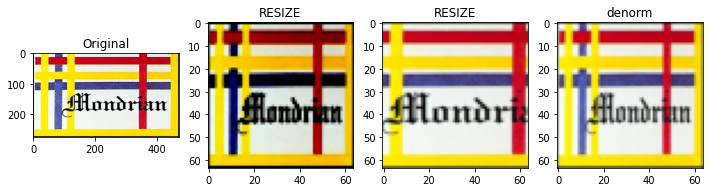

In [21]:
image = Image.open(all_painting_paths[7500])
plt.figure(figsize = (12,12))
print(image.size)
plt.subplot(141)
plt.imshow(image)
plt.title('Original')

image_t1 = transform(image)
print(image_t1.shape)
plt.subplot(142)
plt.imshow(image_t1.clamp(0, 1).numpy().transpose(1,2,0))
plt.title('RESIZE')


image_t2 = transform2(image)
print(image_t2.shape)
plt.subplot(143)
plt.imshow(image_t2.clamp(0, 1).numpy().transpose(1,2,0))
plt.title('RESIZE');


plt.subplot(144)
plt.imshow(denorm(image_t1).numpy().transpose(1,2,0))
plt.title('denorm');


In [22]:
images_tensor =torch.stack((image_t1, image_t2))

In [23]:
sample_dir = os.path.join(DIR,'generated')
os.makedirs(sample_dir, exist_ok=True)

save_image(denorm(transforms.Resize(128)(images_tensor)).clamp(0, 1), os.path.join(sample_dir, 'test_2.png'), nrow=8)

In [24]:

def save_samples(index, latent_tensors,sample_dir = sample_dir, resize_size=128, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    fake_images = images_tensor =torch.stack((image_t1, image_t2))
    save_image(denorm(transforms.Resize(resize_size)(fake_images)).clamp(0, 1), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
#save_samples(0, latent_tensors=None,sample_dir = sample_dir, resize_size=128, show=True)

## Dataset + dataloader

In [25]:
dataset_test = Art_Dataset(all_painting_paths, all_labels, transform=transform)
print(len(dataset_test))

12404


In [26]:
batch_size = 16
dataloader_test = DataLoader(dataset_test,
    batch_size=batch_size,
    shuffle=True)

## show 1 batch

tensor([ 4,  6, 13,  3, 20,  0,  3, 20, 21, 14, 11, 14, 18, 20,  4, 16])
('/mydrive/GAN/Data/david-burliuk/woman-with-wooden-bucket-and-yellow-horse.jpg', '/mydrive/GAN/Data/ernst-ludwig-kirchner/sledge-in-the-fog-1929.jpg', '/mydrive/GAN/Data/pablo-picasso/woman-with-cap-1901.jpg', '/mydrive/GAN/Data/claude-monet/water-lily-pond.jpg', '/mydrive/GAN/Data/vincent-van-gogh/sketch-of-cows-and-children-1890.jpg', '/mydrive/GAN/Data/amedeo-modigliani/a-blond-wearing-earrings.jpg', '/mydrive/GAN/Data/claude-monet/boats-at-rouen.jpg', '/mydrive/GAN/Data/vincent-van-gogh/cypresses-1889-2.jpg', '/mydrive/GAN/Data/zdzislaw-beksinski/untitled-447.jpg', '/mydrive/GAN/Data/pierre-auguste-renoir/breton-landscape-trees-and-moor-1892.jpg', '/mydrive/GAN/Data/joseph-mallord-william-turner/the-morning-after-the-deluge.jpg', '/mydrive/GAN/Data/pierre-auguste-renoir/young-man-in-a-red-tie-portrait-of-eugene-renoir-1890.jpg', '/mydrive/GAN/Data/theophile-steinlen/vente-de-charite-1916-1.jpg', '/mydrive/GAN

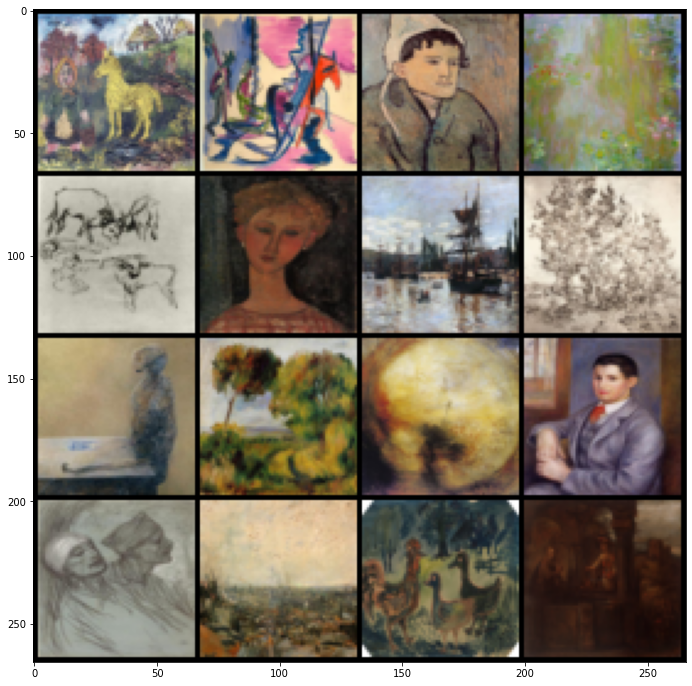

In [27]:
stop = 0
for i, (images, labels, image_paths) in  enumerate(dataloader_test):
  print(labels)
  print(image_paths)
  show_batch(images, num_images=25, size=(3, 64, 64), nrow=4, show=True)
  if i == stop:
    break

# MODEL ARCHITECTURE 

## Discriminator

In [28]:
64*8

512

In [29]:
# from https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%204/C1W4A_Build_a_Conditional_GAN_original.ipynb
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            self.make_disc_block(im_chan, hidden_dim,  kernel_size=4, stride=2, padding=0),
            self.make_disc_block(hidden_dim, hidden_dim * 2,  kernel_size=4, stride=2, padding=0),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4,  kernel_size=4, stride=1, padding=0),
            self.make_disc_block(hidden_dim*4, hidden_dim * 8,  kernel_size=4, stride=2, padding=0),
            self.make_disc_block(hidden_dim*8,1, kernel_size=4, stride=2, padding=0,final_layer=True),
        )


    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        # print('discriminator input shape', image.shape)
        # #-- to display layer output's shape
        # for layer in self.disc:
        #     print(layer)
        #     image = layer(image)
        #     print(image.shape) 
        #     print("-------")
        # print('disc_pred shape', disc_pred.shape) # disc_pred shape torch.Size([BS, 2, 1, 1])
        return disc_pred.view(len(disc_pred), -1) # torch.Size([BS, 2])





## Generator

In [30]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network |  Input: N x channels_noise x 1 x 1
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 16, kernel_size=4, stride=1,padding=0),
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim*2, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim*2, im_chan, kernel_size=4,stride=2, padding=1,final_layer=True),
        ) # => Output: N x channels_img x hidden_dim x hidden_dim



    # def __init__(self, channels_noise, channels_img, features_g):
    #     super(Generator, self).__init__()
    #     self.net = nn.Sequential(
    #         # Input: N x channels_noise x 1 x 1
    #         self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
    #         self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
    #         self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
    #         self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
    #         nn.ConvTranspose2d(
    #             features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
    #         ),
    #         # Output: N x channels_img x 64 x 64
    #         nn.Tanh(),
    #     )




    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        #print('Generator input shape', noise.shape)
        x = noise.view(len(noise), self.input_dim, 1, 1)
        # print('X shape:', x.shape)
        # #-- to display layer output's shape
        # for layer in self.gen:
        #     print(layer)
        #     x = layer(x)
        #     print(x.shape) 
        #     print("-------")

        
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

# Class Input
In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you

## one hot labels

In [31]:
n_classes  = len(artist_map_dic) 
print(f'n_classes parameter : {n_classes}')

n_classes parameter : 22


In [32]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

tensor([ 8, 10,  0, 14,  8, 12,  8, 20,  4, 18, 18, 16, 18,  3, 12, 20])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 

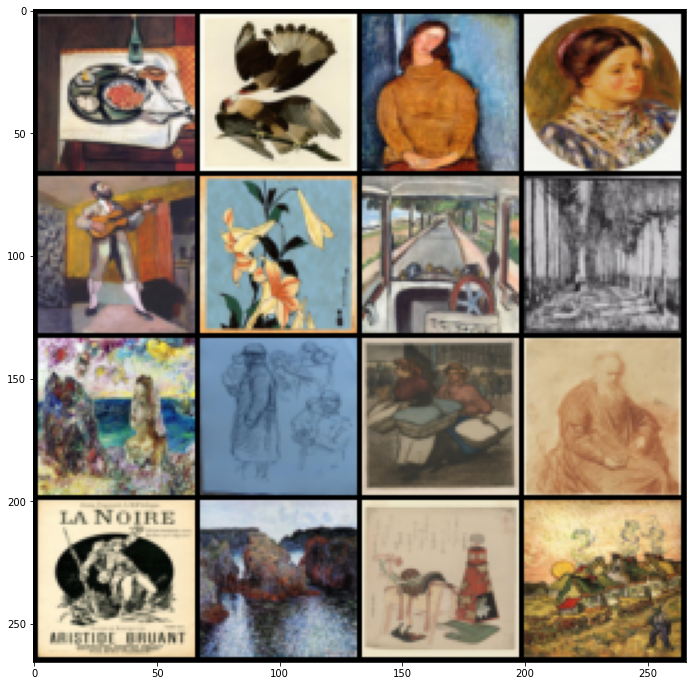

In [33]:
# test 
stop = 0
for i, (images, labels, image_paths) in  enumerate(dataloader_test):
  print(labels)
  one_hot_labels = get_one_hot_labels(labels,n_classes)
  print(one_hot_labels)
  show_batch(images, num_images=25, size=(3, 64, 64), nrow=4, show=True)
  if i == stop:
    break

##  Concatenate the one-hot class vector to the noise vector

Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats. Again, you can look to the PyTorch library for help.

In [34]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

torch.Size([16, 22])
torch.Size([16, 3])
tensor([[ 0.2403, -0.5516, -0.5697,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000],
        [ 1.0076, -0.0770, -1.0205,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000],
        [-0.1690,  0.9178, -0.3155,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.3656, -0.6605, -0.1104,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0

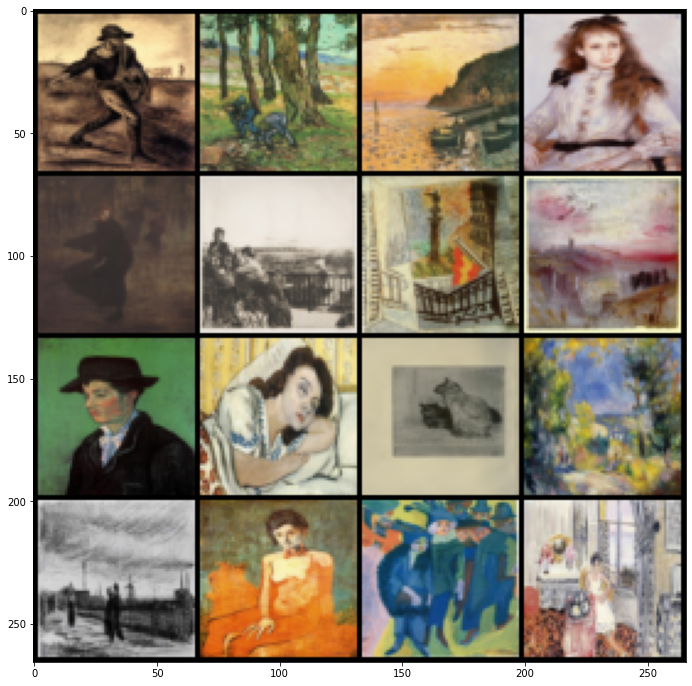

In [35]:
stop = 0
for i, (images, labels, image_paths) in enumerate(dataloader_test):
  one_hot_labels = get_one_hot_labels(labels,n_classes)
  print(one_hot_labels.shape)
  noise_vector = torch.randn(len(one_hot_labels), 3)
  print(noise_vector.shape)
  combined_vectors = combine_vectors(noise_vector, one_hot_labels)
  print(combined_vectors)
  show_batch(images, num_images=25, size=(3, 64, 64), nrow=4, show=True)

  if i == stop:
    break

# Training

## parameters

In [36]:
# -- initialize the device
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

criterion = nn.BCEWithLogitsLoss() # This loss combines a Sigmoid layer and the BCELoss in one single class
n_epochs_start = 0
n_epochs = n_epochs_start + 500
z_dim = 124
display_step = 400
batch_size = 64
lr = 1e-4
hidden_dim=64
SAVE_EPOCH = 50
model_save_DIR = os.path.join(DIR,'Models')

# D_lr = 2e-4
# G_lr = 1e-4
Channel_img = 3
input_shape = (3, 64, 64)
n_classes = len(artist_map_dic) 

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transform = transforms.Compose([transforms.Resize(input_shape[1:]),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

dataset = Art_Dataset(all_painting_paths, all_labels, transform=transform)

dataloader = DataLoader(dataset,
    batch_size=batch_size,
    shuffle=True)

## Input Dimension


Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [37]:
def get_input_dimensions(z_dim, input_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = input_shape[0] + n_classes
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [38]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, input_shape, n_classes)
print(f'Generator input dim (dim noise + n_classes): {generator_input_dim}')
print(f'Discriminator input channels (channel nb + n_classes): {discriminator_im_chan}')

Generator input dim (dim noise + n_classes): 146
Discriminator input channels (channel nb + n_classes): 25


## GENERATOR and DISCRIMNATOR INSTANCES

In [39]:
gen = Generator(input_dim=generator_input_dim, im_chan=3, hidden_dim=64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [40]:
print_network(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(146, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): C

In [41]:
print_network(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(25, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential

## Weights initialization

In [42]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### if checkpoint

In [43]:
!ls gdrive/MyDrive/GAN/Models

2021_10_01_GAN_v1_corrige_100_latest.pkl  art_2
2021_10_01_GAN_v1_corrige_200_latest.pkl  by_artist
2021_10_01_GAN_v1_corrige_300_latest.pkl  by_artist_2
2021_10_01_GAN_v1_corrige_400_latest.pkl  by_genre
2021_10_01_GAN_v1_corrige_450_latest.pkl  by_genre_2
2021_10_01_GAN_v1_corrige_50_latest.pkl


In [44]:
#ckpt_path = 'gdrive/MyDrive/GAN/Models/' + '2021_07_15_GAN_v1_249_latest.pkl'
ckpt_path =None 
if ckpt_path is not None:
    ckpt = torch.load(ckpt_path)
    gen.load_state_dict(ckpt['gen_state_dict'])
    disc.load_state_dict(ckpt['disc_state_dict'])
    gen_opt.load_state_dict(ckpt['gen_optimizer_state_dict'])
    disc_opt.load_state_dict(ckpt['disc_optimizer_state_dict'])


Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:

- Tell that to the generator, so that it knows it should be generating a "1"
- Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake
There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

## To save  Fake samples 

In [45]:
sample_dir = os.path.join(DIR,'generated')
os.makedirs(sample_dir, exist_ok=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, fixed_noise,sample_dir = sample_dir, resize_size=128, show=True):
    fake_images = gen(fixed_noise)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(transforms.Resize(resize_size)(fake_images)).clamp(0, 1), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

In [46]:
# x = torch.tensor([[1,0,0],[0,0,1]])
# print(x)
# print(x.shape)
# x = x[:, :, None, None] 
# print(x)
# x =x.repeat(1, 1, 16, 16)
# print('____')
# print(x[1])

In [47]:
# fixed_labels = torch.tensor(list(np.arange(0,n_classes))*3)
# print('')
# print(fixed_labels.shape)
# x = get_one_hot_labels(fixed_labels.to(device), n_classes)


In [48]:
### uncomment to work from saved models ###

#gen.load_state_dict(torch.load('saved_models/generator_model.pt'))
#disc.load_state_dict(torch.load('saved_models/discriminator_model.pt')) 


In [49]:
len(dataloader)

194

In [50]:
fixed_labels  = torch.tensor(list(np.arange(0,n_classes))*3).to(device)
fixed_noise = get_noise(fixed_labels.shape[0], z_dim, device=device)
print(fixed_labels.shape)
print(fixed_noise.shape)

combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))
#noise_and_labels = combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))

torch.Size([66])
torch.Size([66, 124])


tensor([[-2.9621,  0.1187, -1.6673,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1567, -0.3366,  0.8390,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8153,  0.7726,  2.2218,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3942, -1.2397,  0.7513,  ...,  1.0000,  0.0000,  0.0000],
        [-1.1648, -0.3834,  0.9368,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.8957, -0.4172,  1.2093,  ...,  0.0000,  0.0000,  1.0000]],
       device='cuda:0')

In [51]:
print(fixed_labels)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19, 20, 21,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], device='cuda:0')


In [ ]:
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(146, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): C

## Train

  0%|          | 0/194 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

  0%|          | 0/194 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

  0%|          | 0/194 [00:00<?, ?it/s]

Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
 

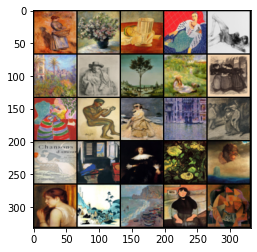

--fake images ---


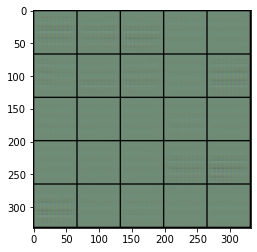

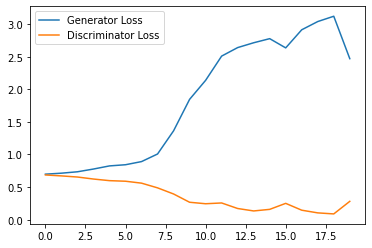

Streaming output truncated to the last 5000 lines.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

  0%|          | 0/194 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

  0%|          | 0/194 [00:00<?, ?it/s]

Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
 

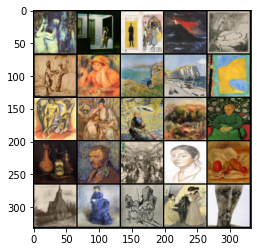

--fake images ---


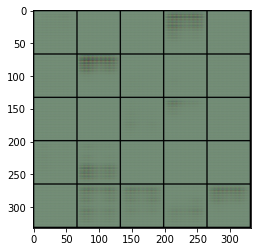

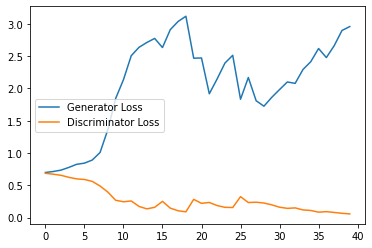

Streaming output truncated to the last 5000 lines.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

  0%|          | 0/194 [00:00<?, ?it/s]

Generator input shape torch.Size([64, 146])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Generator input shape torch.Size([64, 146])
tensor([[0.],
 

In [ ]:
date = datetime.now().strftime("%Y_%m_%d")

generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False


fixed_labels  = torch.tensor(list(np.arange(0,n_classes))*3).to(device)
fixed_noise = get_noise(fixed_labels.shape[0],z_dim, device=device)

writer  =  SummaryWriter(os.path.join(DIR,'logs'))
writer_real = SummaryWriter(os.path.join(DIR,'logs','real'))
writer_fake = SummaryWriter(os.path.join(DIR,'logs','fake'))

printing = False

cur_step = 0
for epoch in range(n_epochs_start, n_epochs):

    #  -- Dataloader returns the batches and the labels
    for real, labels, paths in tqdm(dataloader):
        cur_batch_size = len(real)
        # -- Flatten the batch of real images from the dataset
        real = real.to(device)
        if printing  :
          print(labels)

        # --- label encoding 
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes) # [Batch_size x n_classes]
        image_one_hot_labels = one_hot_labels[:, :, None, None] 
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, input_shape[1], input_shape[2]) # [Batch_size x n_classes x 64 x 64] | for ex if label = 21 for image #0, the 21th 64*64 "image' will be full of 1 whereas the other one full of 0 
  
        
        ### Update discriminator ###
        # -- Zero out the discriminator gradients
        disc_opt.zero_grad()

        #--  Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device) # [Batch_size x  z_dim]

        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        if printing  :
          print('---- Step 0: Generate fake images ----')
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)


        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 3, 64, 64)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        

        if printing  :
          print('#####  DISCRIMINATOR TRAINING ####')
          print('---- Step 1: Get Discriminator predictions for fake and real images---')
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        # -- predictions for fake images + detach generator
        disc_fake_pred = disc(fake_image_and_labels.detach())
        if printing:
            print(disc_fake_pred)
            print('disc_fake_pred SHAPE')
        # -- predictions for Real images 
        disc_real_pred = disc(real_image_and_labels)
        if printing  :
            print(f'Discriminator output shape {disc_fake_pred.shape}')
            print(f'Discriminator output : {disc_fake_pred}')

        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 64 ,64)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 64 ,64)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)


        if printing :
          print('---- Step 2: Calcul loss and do backpropagation for discriminator---')
          print(torch.zeros_like(disc_fake_pred))
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # fake -> label = 0
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))  # real -> label = 1
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # -- Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ########################
        ### Update generator ###
        ########################
        if printing  :
          print('#### GENERATOR training ####')

        # -- Zero out the generator gradients
        gen_opt.zero_grad()

        # Generator recreate new fake images  with the label corresponding to those from the image in the batch 
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        # -- This will error if you didn't concatenate your labels to your image correctly
        # -- predictions for fake images labeled as Real (label=1)
        disc_fake_pred = disc(fake_image_and_labels)
        if printing :
          print('----Step 3: Calcul loss and do backpropagation for the generator---')
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # -- Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch} | Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            print('--real images ---')
            show_tensor_images(real)
            print('--fake images ---')
            show_tensor_images(fake)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

            # -- write to writer
            writer.add_scalar("gen_loss", gen_mean,cur_step)
            writer.add_scalar("dis_loss", disc_mean, cur_step)
            
            # -- save image 
            with torch.no_grad():
              noise_and_labels = combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))
              fake = gen(noise_and_labels)
              img_grid_real = torchvision.utils.make_grid(
                   real, normalize=True)
              img_grid_fake = torchvision.utils.make_grid(
                  fake, normalize=True)
              writer_real.add_image("Real", img_grid_real, global_step=cur_step)
              writer_fake.add_image("Fake", img_grid_fake, global_step=cur_step)

              # torch.save({
              #     'gen_state_dict': gen.state_dict(),
              #     'disc_state_dict': disc.state_dict(),
              #     'gen_optimizer_state_dict': gen_opt.state_dict(),
              #     'disc_optimizer_state_dict': disc_opt.state_dict(),
              #     }, os.path.join(model_save_DIR, f'{date}_GAN_v1_{epoch}_{cur_step}.pkl'))
    

        cur_step += 1
    # -- save the model at the end of the epoch 
    if epoch % SAVE_EPOCH == 0 and epoch > 0:

        # -- save the model at the end of the epoch 
        torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'gen_optimizer_state_dict': gen_opt.state_dict(),
        'disc_optimizer_state_dict': disc_opt.state_dict(),
        }, os.path.join(model_save_DIR, f'{date}_GAN_v1_corrige_{epoch}_latest.pkl'))

        print('saving images generated with fixed noise')
        save_samples(epoch, noise_and_labels,sample_dir = sample_dir, resize_size=128, show=True)
        print('------------------------------------------------------------------------------------')

        
